In [1]:
# ==========================
# 0️⃣ Install & Imports
# ==========================

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

In [2]:
# ==========================
# 1️⃣ Check GPU
# ==========================
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# Check GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs detected:", gpus)
else:
    print("No GPU detected")

# Check if TensorFlow is built with GPU support
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.config.list_physical_devices('GPU'))

# Check runtime GPU availability
print("GPU available at runtime:", tf.test.is_gpu_available(cuda_only=True, min_cuda_compute_capability=None))

# Print device details
from tensorflow.python.client import device_lib
print("\nLocal devices:")
for d in device_lib.list_local_devices():
    print(f"{d.name} | Type: {d.device_type}")


TensorFlow version: 2.13.1
No GPU detected
Built with CUDA: False
Built with GPU support: []
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available at runtime: False

Local devices:
/device:CPU:0 | Type: CPU


In [3]:
# ==========================
# 2️⃣ Dataset Paths
# ==========================
dataset_path = r"C:\Users\USER\Desktop\CNNmodel\rawdata\dataset"
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")
img_size = (224, 224)
batch_size = 32

In [4]:
# ==========================
# 3️⃣ Data Augmentation
# ==========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7,1.3],
    zoom_range=0.15,
    shear_range=0.10,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rescale=1./255

)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
print("Number of classes:", num_classes)

# ==========================
# Count images per class
# ==========================
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                         if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = count
    return class_counts

train_counts = count_images(train_dir)
valid_counts = count_images(valid_dir)

print("Train images per class:", train_counts)
print("Validation images per class:", valid_counts)


Found 2101 images belonging to 5 classes.
Found 833 images belonging to 5 classes.
Number of classes: 5
Train images per class: {'fist': 418, 'one': 378, 'palm': 432, 'thumb': 445, 'two': 428}
Validation images per class: {'fist': 169, 'one': 156, 'palm': 183, 'thumb': 152, 'two': 173}


In [5]:
# ==========================
# 4️⃣ MobileNetV2 Model Setup
# ==========================
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')

# Freeze all layers first
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

# ==========================
# 5️⃣ Compile Model
# ==========================
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [6]:
# ==========================
# 6️⃣ Callbacks
# ==========================
checkpoint = ModelCheckpoint("best_mobilenetv2_tf.h5", monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

callbacks = [checkpoint, early_stop, reduce_lr]


In [7]:
# ==========================
# 7️⃣ Train Model (Phase 1)
# ==========================
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=callbacks
)

Epoch 1/15
66/66 [==============================] - ETA: 0s - loss: 0.8926 - accuracy: 0.7144

C:\Users\USER\ml_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 71s 1s/step - loss: 0.8926 - accuracy: 0.7144 - val_loss: 0.7517 - val_accuracy: 0.7839 - lr: 1.0000e-04
Epoch 2/15
66/66 [==============================] - 61s 929ms/step - loss: 0.2644 - accuracy: 0.9743 - val_loss: 0.5268 - val_accuracy: 0.8451 - lr: 1.0000e-04
Epoch 3/15
66/66 [==============================] - 61s 927ms/step - loss: 0.1364 - accuracy: 0.9929 - val_loss: 0.4536 - val_accuracy: 0.8583 - lr: 1.0000e-04
Epoch 4/15
66/66 [==============================] - 62s 934ms/step - loss: 0.0861 - accuracy: 0.9948 - val_loss: 0.4008 - val_accuracy: 0.8643 - lr: 1.0000e-04
Epoch 5/15
66/66 [==============================] - 61s 929ms/step - loss: 0.0649 - accuracy: 0.9933 - val_loss: 0.3700 - val_accuracy: 0.8739 - lr: 1.0000e-04
Epoch 6/15
66/66 [==============================] - 61s 924ms/step - loss: 0.0500 - accuracy: 0.9962 - val_loss: 0.3621 - val_accuracy: 0.8679 - lr: 1.0000e-04
Epoch 7/15
66/66 [==============================] - 61

In [8]:
# ==========================
# 8️⃣ Fine-tune last layers (Phase 2)
# ==========================
# Unfreeze last 20 layers of the base_model
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=callbacks
)

Epoch 1/30
66/66 [==============================] - 72s 1s/step - loss: 0.1033 - accuracy: 0.9786 - val_loss: 0.2665 - val_accuracy: 0.8956 - lr: 1.0000e-05
Epoch 2/30
66/66 [==============================] - 66s 992ms/step - loss: 0.0429 - accuracy: 0.9938 - val_loss: 0.2586 - val_accuracy: 0.8980 - lr: 1.0000e-05
Epoch 3/30
66/66 [==============================] - 65s 990ms/step - loss: 0.0294 - accuracy: 0.9967 - val_loss: 0.2433 - val_accuracy: 0.9064 - lr: 1.0000e-05
Epoch 4/30
66/66 [==============================] - 66s 990ms/step - loss: 0.0217 - accuracy: 0.9971 - val_loss: 0.2361 - val_accuracy: 0.9124 - lr: 1.0000e-05
Epoch 5/30
66/66 [==============================] - 65s 985ms/step - loss: 0.0166 - accuracy: 0.9981 - val_loss: 0.2251 - val_accuracy: 0.9160 - lr: 1.0000e-05
Epoch 6/30
66/66 [==============================] - 65s 986ms/step - loss: 0.0140 - accuracy: 0.9981 - val_loss: 0.2162 - val_accuracy: 0.9184 - lr: 1.0000e-05
Epoch 7/30
66/66 [=========================

27/27 [==============================] - 13s 439ms/step


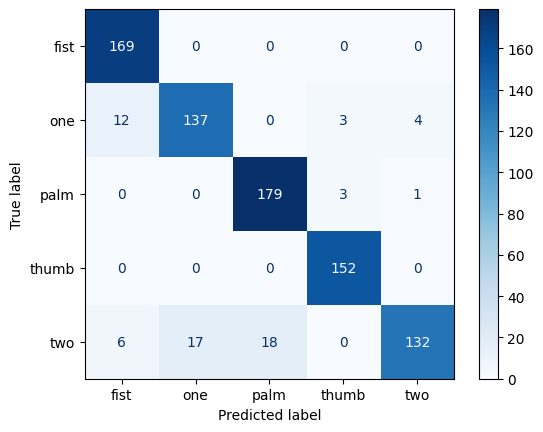


=== Confusion Matrix ===
Rows = true labels, Columns = predicted labels
Classes: ['fist', 'one', 'palm', 'thumb', 'two']
[[169   0   0   0   0]
 [ 12 137   0   3   4]
 [  0   0 179   3   1]
 [  0   0   0 152   0]
 [  6  17  18   0 132]]

=== Per-class Accuracy ===
Class 'fist': 100.00%
Class 'one': 87.82%
Class 'palm': 97.81%
Class 'thumb': 100.00%
Class 'two': 76.30%


In [9]:
# ========================== 
# 9️⃣ Evaluate & Confusion Matrix (Updated)
# ==========================
valid_generator.reset()
preds = model.predict(valid_generator)
y_pred = np.argmax(preds, axis=1)
y_true = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())

# Confusion Matrix (plot)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Confusion Matrix (terminal)
print("\n=== Confusion Matrix ===")
print("Rows = true labels, Columns = predicted labels")
print("Classes:", class_labels)
print(cm)

# Per-class accuracy
class_acc = cm.diagonal() / cm.sum(axis=1) * 100
print("\n=== Per-class Accuracy ===")
for cls, acc in zip(class_labels, class_acc):
    print(f"Class '{cls}': {acc:.2f}%")


=== Average Precision (AP) per class ===
fist: 1.0000
one: 0.9520
palm: 0.9957
thumb: 1.0000
two: 0.9640

🔥 mAP (mean Average Precision): 0.9823


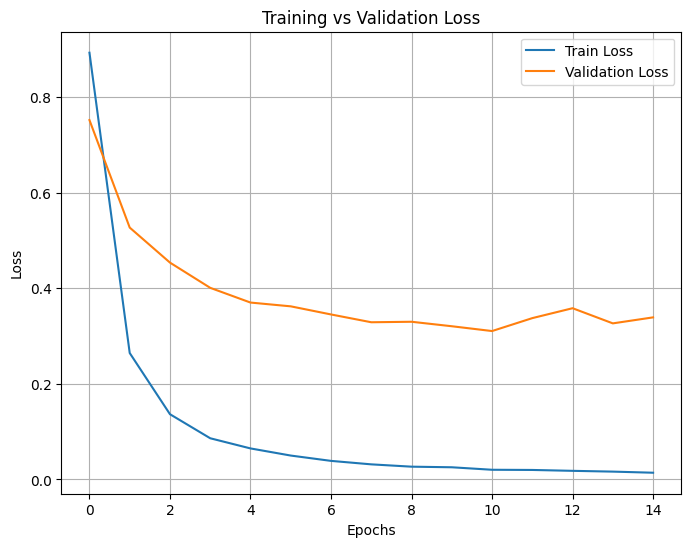

In [12]:
from sklearn.metrics import average_precision_score
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# -----------------------------
# Convert true labels to one-hot
# -----------------------------
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_labels))

# -----------------------------
# Compute AP per class
# -----------------------------
ap_scores = {}
for i, cls in enumerate(class_labels):
    ap = average_precision_score(y_true_onehot[:, i], preds[:, i])
    ap_scores[cls] = ap

# -----------------------------
# Print AP & mAP
# -----------------------------
print("\n=== Average Precision (AP) per class ===")
for cls, ap in ap_scores.items():
    print(f"{cls}: {ap:.4f}")

mAP = np.mean(list(ap_scores.values()))
print(f"\n🔥 mAP (mean Average Precision): {mAP:.4f}")

# ============================================================
# 📈 TRAIN / VALIDATION LOSS GRAPH
# history must come from model.fit()
# ============================================================

# Example: if you saved history as a numpy file or pickle,
# load it here (skip this if you already have `history`)
# history = np.load("history.npy", allow_pickle=True).item()

plt.figure(figsize=(8,6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



In [11]:
# ==========================
# 🔟 Save Final Model
# ==========================
import os
import tensorflow as tf
import tf2onnx

# ----------------------------
# Paths
# ----------------------------
h5_path       = r"C:\Users\USER\Desktop\CNNmodel\models\mobilenetv2_gesture_tf_full.h5"
keras_path    = r"C:\Users\USER\Desktop\CNNmodel\models\mobilenetv2_gesture_tf_full.keras"
saved_model_dir = r"C:\Users\USER\Desktop\CNNmodel\models\mobilenetv2_gesture_savedmodel"
onnx_path     = r"C:\Users\USER\Desktop\CNNmodel\models\mobilenetv2_gesture.onnx"

# ----------------------------
# 1️⃣ Save as HDF5 (legacy)
# ----------------------------
model.save(h5_path)
print(f"✅ Model saved as HDF5: {h5_path}")

# ----------------------------
# 2️⃣ Save as native Keras (.keras)
# ----------------------------
model.save(keras_path)
print(f"✅ Model saved as native Keras: {keras_path}")

# ----------------------------
# 3️⃣ Save as TensorFlow SavedModel
# ----------------------------
os.makedirs(saved_model_dir, exist_ok=True)
model.save(saved_model_dir)
print(f"✅ Model saved as TensorFlow SavedModel: {saved_model_dir}")

# ----------------------------
# 4️⃣ Convert to ONNX
# ----------------------------
# Define input signature (batch dimension = None)
input_signature = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)

# Convert Keras model to ONNX
model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=input_signature,
    opset=11,
    output_path=onnx_path
)
print(f"✅ ONNX model exported at: {onnx_path}")


C:\Users\USER\ml_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Model saved as HDF5: C:\Users\USER\Desktop\CNNmodel\models\mobilenetv2_gesture_tf_full.h5
✅ Model saved as native Keras: C:\Users\USER\Desktop\CNNmodel\models\mobilenetv2_gesture_tf_full.keras
INFO:tensorflow:Assets written to: C:\Users\USER\Desktop\CNNmodel\models\mobilenetv2_gesture_savedmodel\assets


INFO:tensorflow:Assets written to: C:\Users\USER\Desktop\CNNmodel\models\mobilenetv2_gesture_savedmodel\assets


✅ Model saved as TensorFlow SavedModel: C:\Users\USER\Desktop\CNNmodel\models\mobilenetv2_gesture_savedmodel
✅ ONNX model exported at: C:\Users\USER\Desktop\CNNmodel\models\mobilenetv2_gesture.onnx
